# Importar librerias y configuraciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from typing import Union

# RLM - 1 -  Índices espectrales Climáticas Topográficas

In [2]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])
X = df.select_dtypes(include=['float64', 'int64'])

X = df.drop(columns = ['REND_mean',
                       'NDRE_stde', 'NDRE_range', 
                       'SLOPE_stde','SLOPE_range', 
                       'GNDVI_stde', 'GNDVI_range',
                        'NDVI_stde', 'NDVI_range', 
                       'OSAVI_stde', 'OSAVI_range',
                       'RECI_stde', 'RECI_range',
                       'TCARIOSAVI_stde', 'TCARIOSAVI_range', 
                       'TCARI_stde', 'TCARI_range'])


#### Modelado

In [3]:
y = df['REND_mean']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=1234,shuffle=True) #.values.reshape(-1,1),
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

#El error (rmse) del test
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse:.2f}")

#Test de normalidad de los reiduos -  Shapiro Wilk 
prediccion_train= modelo.predict(exog = X_train)
residuos_train= prediccion_train-y_train

shapiro_test = stats.shapiro(residuos_train)

if shapiro_test.pvalue > 0.05:
    print("El test de Shapiro-Wilk indica que los residuos son normalmente distribuidos (p > 0.05)")
else:
    print("El test de Shapiro-Wilk indica que los residuos no son normalmente distribuidos (p <= 0.05)")

print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)

                            OLS Regression Results                            
Dep. Variable:              REND_mean   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     2.301
Date:                Thu, 28 Sep 2023   Prob (F-statistic):             0.0752
Time:                        13:16:39   Log-Likelihood:                -45.867
No. Observations:                  26   AIC:                             117.7
Df Residuals:                      13   BIC:                             134.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              39.7584     29.792     

#### Grafico de los residuos

C:\Users\dncarcedo\AppData\Local\Temp\ipykernel_1640\1078019318.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


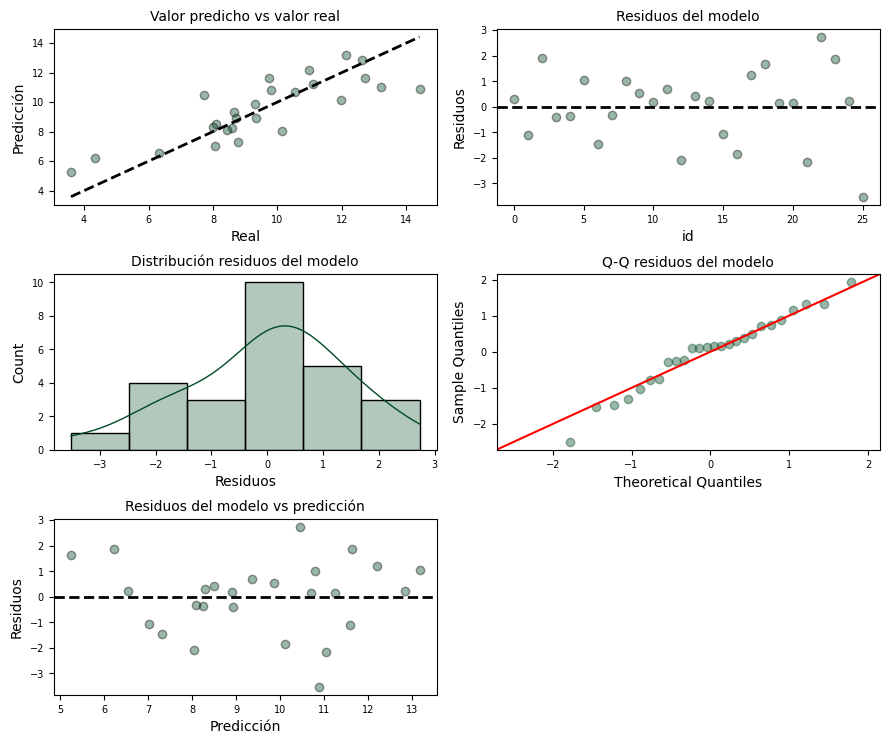

In [4]:
# Importar la librería Seaborn y establecer un esquema de color azul (celeste)

sns.set_palette("ocean")
# Diagnóstico errores (residuos) de las predicciones de entrenamiento
# ==============================================================================

prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize=7)

# 2 - Gráfico Residuos del Modelo
axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize=10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].tick_params(labelsize=7)

# 3 - Gráfico Distribución Residuos del Modelo
sns.histplot(data=residuos_train, stat="count", kde=True, line_kws={'linewidth': 1},alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuos")
axes[1, 0].tick_params(labelsize=7)

# 4 - Gráfico Q-Q Residuos del Modelo
sm.qqplot(residuos_train, fit=True, line='45', ax=axes[1, 1], color='black', alpha=0.4, lw=2)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

# 5 - Gráfico Residuos del Modelo vs Predicción
axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuos')
axes[2, 0].tick_params(labelsize=7)

# Eliminar los axes vacíos
fig.delaxes(axes[2, 1])

# Ajustar diseño de la figura y título
fig.tight_layout()
plt.subplots_adjust(top=0.9)
#fig.suptitle('Diagnóstico residuos RLM - MEDIAS + clima ', fontsize=12)

# Mostrar los gráficos
plt.show()


#  RLM - 2- PCA

In [5]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])
df = df.drop(columns = [
                       'NDRE_stde', 'NDRE_range', 
                       'SLOPE_stde','SLOPE_range', 
                       'GNDVI_stde', 'GNDVI_range',
                        'NDVI_stde', 'NDVI_range', 
                       'OSAVI_stde', 'OSAVI_range',
                       'RECI_stde', 'RECI_range',
                       'TCARIOSAVI_stde', 'TCARIOSAVI_range', 
                       'TCARI_stde', 'TCARI_range'])
df = df.astype(float)
#df.info()

scaler = StandardScaler()
X_std = scaler.fit_transform(df)
n_components = 3  # Número de componentes principales a conservar
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_std)
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)])
#principal_df.info()

explained_variance_ratio = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:", explained_variance_ratio)
print("Varianza total explicada:", sum(explained_variance_ratio))

Varianza explicada por cada componente principal: [0.47614894 0.21919704 0.1113091 ]
Varianza total explicada: 0.8066550785957869


In [6]:
# Concatenar las componentes principales con tu DataFrame original
df_with_pca = pd.concat([df['REND_mean'], principal_df], axis=1) #['REND_mean']
X = df_with_pca.drop(columns = ['REND_mean'])
y = df_with_pca['REND_mean']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     33 non-null     float64
 1   PC2     33 non-null     float64
 2   PC3     33 non-null     float64
dtypes: float64(3)
memory usage: 920.0 bytes


#### Modelado

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234, shuffle=True)
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

#El error (rmse) del test
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse:.2f}")

#Test de normalidad de los reiduos -  Shapiro Wilk 
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

shapiro_test = stats.shapiro(residuos_train)

if shapiro_test.pvalue > 0.05:
    print("El test de Shapiro-Wilk indica que los residuos son normalmente distribuidos (p > 0.05)")
else:
    print("El test de Shapiro-Wilk indica que los residuos no son normalmente distribuidos (p <= 0.05)")

print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)

                            OLS Regression Results                            
Dep. Variable:              REND_mean   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     13.00
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           4.24e-05
Time:                        13:16:41   Log-Likelihood:                -47.416
No. Observations:                  26   AIC:                             102.8
Df Residuals:                      22   BIC:                             107.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3159      0.323     28.833      0.0

#### Grafico de los residuos

C:\Users\dncarcedo\AppData\Local\Temp\ipykernel_1640\2563696618.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


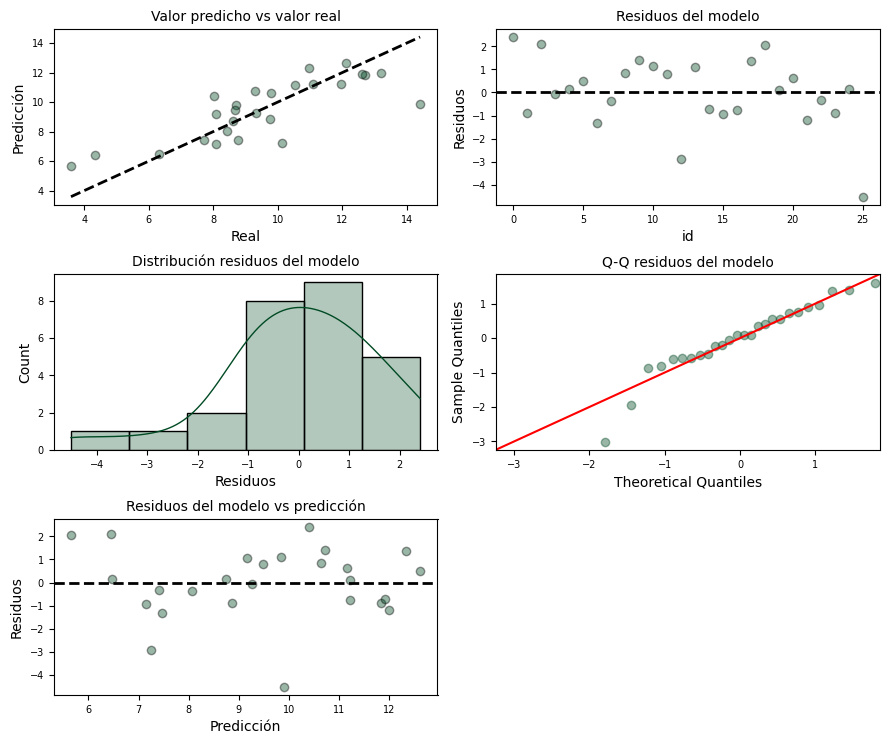

In [8]:
# Importar la librería Seaborn y establecer un esquema de color azul (celeste)

sns.set_palette("ocean")

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize=7)

# 2 - Gráfico Residuos del Modelo
axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize=10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].tick_params(labelsize=7)

# 3 - Gráfico Distribución Residuos del Modelo
sns.histplot(data=residuos_train, stat="count", kde=True, line_kws={'linewidth': 1},alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuos")
axes[1, 0].tick_params(labelsize=7)

# 4 - Gráfico Q-Q Residuos del Modelo
sm.qqplot(residuos_train, fit=True, line='45', ax=axes[1, 1], color='black', alpha=0.4, lw=2)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

# 5 - Gráfico Residuos del Modelo vs Predicción
axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuos')
axes[2, 0].tick_params(labelsize=7)

# Eliminar los axes vacíos
fig.delaxes(axes[2, 1])

# Ajustar diseño de la figura y título
fig.tight_layout()
plt.subplots_adjust(top=0.9)
#fig.suptitle('Diagnóstico residuos PCA(medias + clima + topo)', fontsize=12)

# Mostrar los gráficos
plt.show()


# RLM - 3 - variables seleccionadas por stepwise (backward)

In [12]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])
df = df.astype(float)

In [13]:
# Concatenar las componentes principales con tu DataFrame original
X = df.drop(columns = ['REND_mean',
                       'NDRE_stde', 'NDRE_range', 
                       'SLOPE_stde','SLOPE_range', 
                       'GNDVI_stde', 'GNDVI_range',
                        'NDVI_stde', 'NDVI_range', 
                       'OSAVI_stde', 'OSAVI_range',
                       'RECI_stde', 'RECI_range',
                       'TCARIOSAVI_stde', 'TCARIOSAVI_range', 
                       'TCARI_stde', 'TCARI_range'])

y = df['REND_mean']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DSM              33 non-null     float64
 1   EVAPO            33 non-null     float64
 2   PP               33 non-null     float64
 3   TEMP             33 non-null     float64
 4   GNDVI_mean       33 non-null     float64
 5   NDRE_mean        33 non-null     float64
 6   NDVI_mean        33 non-null     float64
 7   OSAVI_mean       33 non-null     float64
 8   RECI_mean        33 non-null     float64
 9   SLOPE_mean       33 non-null     float64
 10  TCARIOSAVI_mean  33 non-null     float64
 11  TCARI_mean       33 non-null     float64
dtypes: float64(12)
memory usage: 3.2 KB


In [14]:
y = df['REND_mean']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=1234,shuffle=True) #.values.reshape(-1,1),
X_train = sm.add_constant(X_train, prepend=True)


In [15]:
# Funcion de selecciçon backward para modelos lineales de statsmodels
# ==============================================================================
def backward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:
    
    """
    Realiza un procedimiento de selección de variables hacia atrás (backward) 
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo eliminando variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.
    
    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    # Se inicia con todas las variables como predictores
    seleccion = X.columns.to_list()
    modelo  = sm.OLS(endog=y, exog=X[seleccion])
    modelo_res = modelo.fit()
    ultima_metrica = getattr(modelo_res, criterio)
    mejor_metrica = ultima_metrica
    if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    while seleccion:
        metricas = []
        for candidata in seleccion:
            seleccion_temp = seleccion.copy()
            seleccion_temp.remove(candidata)
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                peor_variable = seleccion[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                peor_variable = seleccion[np.argmin(metricas)]
            else:
                break
                
        seleccion.remove(peor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)

In [16]:
# Selección de variables hacia backward
# ==============================================================================
predictores= backward_selection(
    X            = X_train,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['const', 'DSM', 'EVAPO', 'PP', 'TEMP', 'GNDVI_mean', 'NDRE_mean', 'NDVI_mean', 'OSAVI_mean', 'RECI_mean', 'SLOPE_mean', 'TCARIOSAVI_mean', 'TCARI_mean'] | aic: 117.734
variables: ['const', 'DSM', 'EVAPO', 'PP', 'TEMP', 'GNDVI_mean', 'NDRE_mean', 'NDVI_mean', 'OSAVI_mean', 'SLOPE_mean', 'TCARIOSAVI_mean', 'TCARI_mean'] | aic: 115.794
variables: ['const', 'DSM', 'EVAPO', 'TEMP', 'GNDVI_mean', 'NDRE_mean', 'NDVI_mean', 'OSAVI_mean', 'SLOPE_mean', 'TCARIOSAVI_mean', 'TCARI_mean'] | aic: 113.931
variables: ['const', 'DSM', 'EVAPO', 'TEMP', 'GNDVI_mean', 'NDRE_mean', 'NDVI_mean', 'OSAVI_mean', 'SLOPE_mean', 'TCARI_mean'] | aic: 112.460
variables: ['const', 'DSM', 'EVAPO', 'TEMP', 'GNDVI_mean', 'NDRE_mean', 'NDVI_mean', 'OSAVI_mean', 'TCARI_mean'] | aic: 110.835
variables: ['const', 'DSM', 'EVAPO', 'TEMP', 'GNDVI_mean', 'NDRE_mean', 'NDVI_mean', 'TCARI_mean'] | aic: 109.207
variables: ['const', 'DSM', 'EVAPO', 'TEMP', 'NDRE_mean', 'NDVI_mean', 'TCARI_mean'] | aic: 107.331
variable

['NDVI_mean', 'TCARI_mean', 'TEMP', 'const']

In [17]:
# Entrenamiento del modelo con las variables seleccionadas
# ==============================================================================
modelo_final  = sm.OLS(endog=y_train, exog=X_train[predictores])
modelo_final_res = modelo_final.fit()
print(modelo_final_res.summary())


#El error (rmse) del test
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo_final_res.predict(exog = X_test[predictores])
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse:.2f}")

#Test de normalidad de los reiduos -  Shapiro Wilk 
prediccion_train = modelo_final_res.predict(X_train[predictores])

residuos_train= prediccion_train-y_train

shapiro_test = stats.shapiro(residuos_train)

if shapiro_test.pvalue > 0.05:
    print("El test de Shapiro-Wilk indica que los residuos son normalmente distribuidos (p > 0.05)")
else:
    print("El test de Shapiro-Wilk indica que los residuos no son normalmente distribuidos (p <= 0.05)")

print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)

                            OLS Regression Results                            
Dep. Variable:              REND_mean   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     12.75
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           4.87e-05
Time:                        17:28:57   Log-Likelihood:                -47.581
No. Observations:                  26   AIC:                             103.2
Df Residuals:                      22   BIC:                             108.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NDVI_mean     17.8847      3.599      4.970      0.0

##### Inspección visual

C:\Users\dncarcedo\AppData\Local\Temp\ipykernel_15272\465318298.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


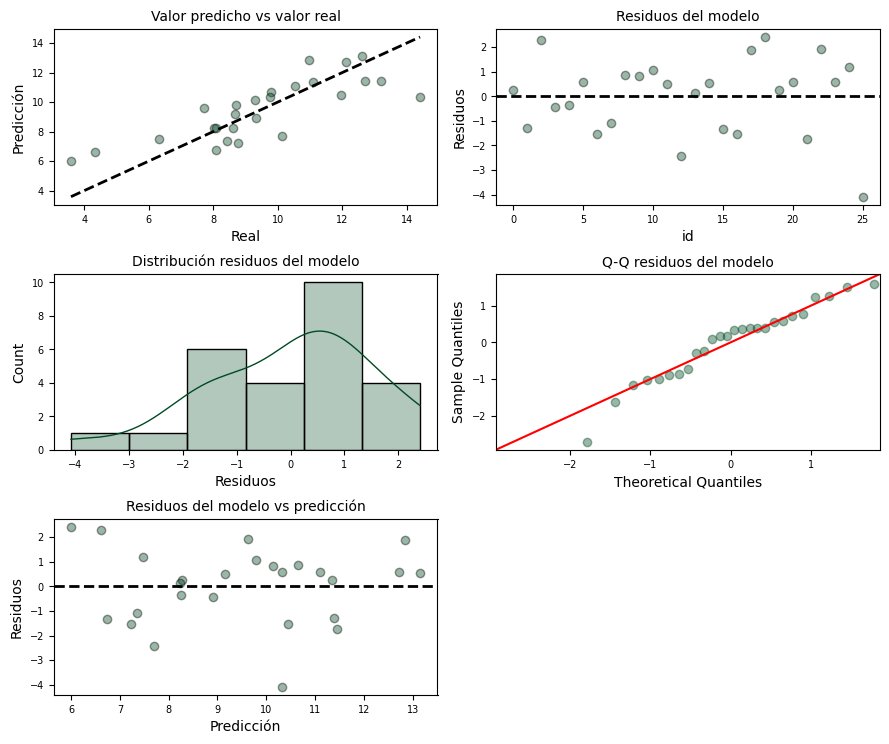

In [18]:
# Importar la librería Seaborn y establecer un esquema de color azul (celeste)

sns.set_palette("ocean")

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize=7)

# 2 - Gráfico Residuos del Modelo
axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize=10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].tick_params(labelsize=7)

# 3 - Gráfico Distribución Residuos del Modelo
sns.histplot(data=residuos_train, stat="count", kde=True, line_kws={'linewidth': 1},alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuos")
axes[1, 0].tick_params(labelsize=7)

# 4 - Gráfico Q-Q Residuos del Modelo
sm.qqplot(residuos_train, fit=True, line='45', ax=axes[1, 1], color='black', alpha=0.4, lw=2)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

# 5 - Gráfico Residuos del Modelo vs Predicción
axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuos')
axes[2, 0].tick_params(labelsize=7)

# Eliminar los axes vacíos
fig.delaxes(axes[2, 1])

# Ajustar diseño de la figura y título
fig.tight_layout()
plt.subplots_adjust(top=0.9)
#fig.suptitle('Diagnóstico residuos RLM MEDIAS + CLIMA + INTERACCIONES', fontsize=12)

# Mostrar los gráficos
plt.show()


# RLM - 4 - variables seleccionadas por stepwise (forward)


In [19]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])
df = df.astype(float)

In [20]:
# Concatenar las componentes principales con tu DataFrame original
X = df.drop(columns = ['REND_mean',
                       'NDRE_stde', 'NDRE_range', 
                       'SLOPE_stde','SLOPE_range', 
                       'GNDVI_stde', 'GNDVI_range',
                        'NDVI_stde', 'NDVI_range', 
                       'OSAVI_stde', 'OSAVI_range',
                       'RECI_stde', 'RECI_range',
                       'TCARIOSAVI_stde', 'TCARIOSAVI_range', 
                       'TCARI_stde', 'TCARI_range'])

y = df['REND_mean']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DSM              33 non-null     float64
 1   EVAPO            33 non-null     float64
 2   PP               33 non-null     float64
 3   TEMP             33 non-null     float64
 4   GNDVI_mean       33 non-null     float64
 5   NDRE_mean        33 non-null     float64
 6   NDVI_mean        33 non-null     float64
 7   OSAVI_mean       33 non-null     float64
 8   RECI_mean        33 non-null     float64
 9   SLOPE_mean       33 non-null     float64
 10  TCARIOSAVI_mean  33 non-null     float64
 11  TCARI_mean       33 non-null     float64
dtypes: float64(12)
memory usage: 3.2 KB


In [21]:
y = df['REND_mean']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=1234,shuffle=True) #.values.reshape(-1,1),
X_train = sm.add_constant(X_train, prepend=True)


In [22]:
# Funcion de selecciçon backward para modelos lineales de statsmodels
# ==============================================================================

def forward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:
    
    """
    Realiza un procedimiento de selección de variables hacia adelante (forward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo añadiendo variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.
    
    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    restantes = X.columns.to_list()
    seleccion = []
    if criterio == 'rsquared_adj':
        mejor_metrica = -np.inf
        ultima_metrica = -np.inf
    else:
        mejor_metrica = np.inf
        ultima_metrica = np.inf

    while restantes:
        metricas = []
        for candidata in restantes:
            seleccion_temp = seleccion + [candidata]
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                mejor_variable = restantes[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                mejor_variable = restantes[np.argmin(metricas)]
            else:
                break
                
        seleccion.append(mejor_variable)
        restantes.remove(mejor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)



In [23]:
# Selección de variables hacia forward
# ==============================================================================
predictores = forward_selection(
    X            = X_train,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['GNDVI_mean'] | aic: 119.308
variables: ['GNDVI_mean', 'TCARI_mean'] | aic: 110.848
variables: ['GNDVI_mean', 'TCARI_mean', 'EVAPO'] | aic: 109.814


['EVAPO', 'GNDVI_mean', 'TCARI_mean']

In [24]:
# Entrenamiento del modelo con las variables seleccionadas
# ==============================================================================
modelo_final  = sm.OLS(endog=y_train, exog=X_train[predictores])
modelo_final_res = modelo_final.fit()
print(modelo_final_res.summary())


#El error (rmse) del test
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo_final_res.predict(exog = X_test[predictores])
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse:.2f}")

#Test de normalidad de los reiduos -  Shapiro Wilk 
prediccion_train = modelo_final_res.predict(X_train[predictores])

residuos_train= prediccion_train-y_train

shapiro_test = stats.shapiro(residuos_train)

if shapiro_test.pvalue > 0.05:
    print("El test de Shapiro-Wilk indica que los residuos son normalmente distribuidos (p > 0.05)")
else:
    print("El test de Shapiro-Wilk indica que los residuos no son normalmente distribuidos (p <= 0.05)")

print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)

                                 OLS Regression Results                                
Dep. Variable:              REND_mean   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              225.8
Date:                Tue, 10 Oct 2023   Prob (F-statistic):                    3.38e-17
Time:                        17:29:35   Log-Likelihood:                         -51.907
No. Observations:                  26   AIC:                                      109.8
Df Residuals:                      23   BIC:                                      113.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

##### Inspección visual

C:\Users\dncarcedo\AppData\Local\Temp\ipykernel_15272\465318298.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


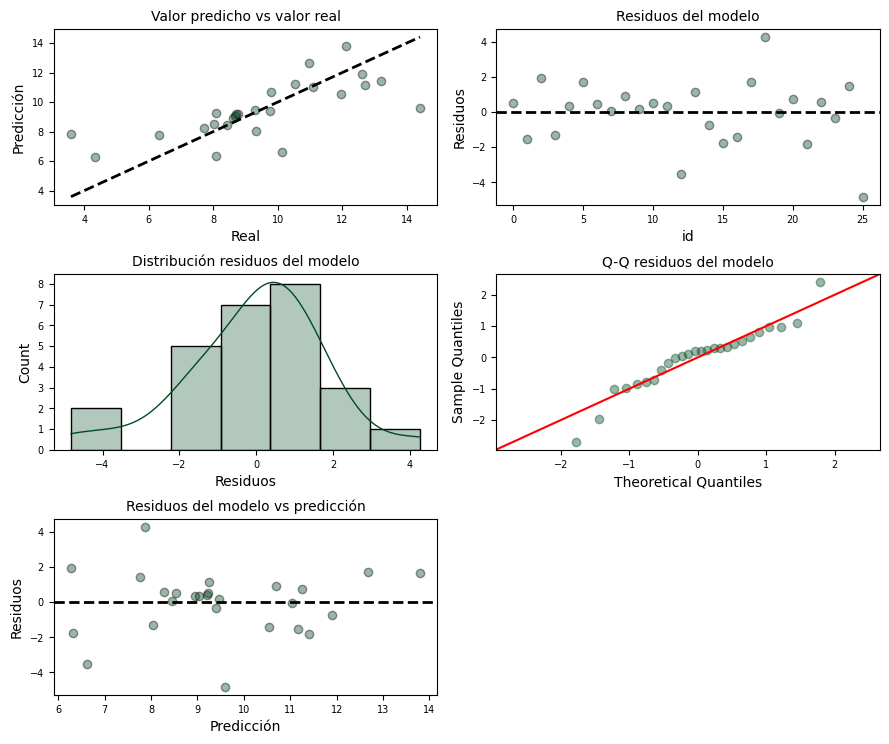

In [25]:
# Importar la librería Seaborn y establecer un esquema de color azul (celeste)

sns.set_palette("ocean")

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize=7)

# 2 - Gráfico Residuos del Modelo
axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize=10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].tick_params(labelsize=7)

# 3 - Gráfico Distribución Residuos del Modelo
sns.histplot(data=residuos_train, stat="count", kde=True, line_kws={'linewidth': 1},alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuos")
axes[1, 0].tick_params(labelsize=7)

# 4 - Gráfico Q-Q Residuos del Modelo
sm.qqplot(residuos_train, fit=True, line='45', ax=axes[1, 1], color='black', alpha=0.4, lw=2)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

# 5 - Gráfico Residuos del Modelo vs Predicción
axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuos')
axes[2, 0].tick_params(labelsize=7)

# Eliminar los axes vacíos
fig.delaxes(axes[2, 1])

# Ajustar diseño de la figura y título
fig.tight_layout()
plt.subplots_adjust(top=0.9)
#fig.suptitle('Diagnóstico residuos RLM MEDIAS + CLIMA + INTERACCIONES', fontsize=12)

# Mostrar los gráficos
plt.show()


## RLM  - 5 - INTERACCIONES STEPWISE (forward)

In [28]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])

X = df.drop(columns = ['REND_mean',
                         
                       'NDRE_stde', 'NDRE_range', 
                       'SLOPE_stde','SLOPE_range', 
                       'GNDVI_stde', 'GNDVI_range',
                        'NDVI_stde', 'NDVI_range', 
                       'OSAVI_stde', 'OSAVI_range',
                       'RECI_stde', 'RECI_range',
                       'TCARIOSAVI_stde', 'TCARIOSAVI_range', 
                       'TCARI_stde', 'TCARI_range'])



y = df['REND_mean']

#### Modelado

In [29]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234, shuffle=True)

# Se añade una nueva columna con la interacción
#['EVAPO', 'GNDVI_mean', 'TCARI_mean']

X_train['EVAPO_GNDVI_mean'] = X_train['EVAPO'] * X_train['GNDVI_mean']
X_test['EVAPO_GNDVI_mean'] = X_test['EVAPO'] * X_test['GNDVI_mean']

X_train['EVAPO_TCARI_mean']  = X_train['EVAPO'] * X_train['TCARI_mean']
X_test['EVAPO_TCARI_mean'] = X_test['EVAPO'] * X_test['TCARI_mean']

X_train['TCARI_GNDVI_mean'] = X_train['TCARI_mean'] * X_train['GNDVI_mean']
X_test['TCARI_GNDVI_mean'] = X_test['TCARI_mean'] * X_test['GNDVI_mean']

#X_train['OSAVI_mean_GNDVI_mean']  = X_train['OSAVI_mean'] * X_train['GNDVI_mean']
#X_test['OSAVI_mean_GNDVI_mean'] = X_test['OSAVI_mean'] * X_test['GNDVI_mean']

#X_train['TCARI_mean_NDRE_mean'] = X_train['TCARI_mean'] * X_train['NDRE_mean']
#X_test['TCARI_mean_NDRE_mean'] = X_test['TCARI_mean'] * X_test['NDRE_mean']


# Agrega una columna de 1s para el intercepto del modelo
X_train = sm.add_constant(X_train, prepend=True)
X_test = sm.add_constant(X_test, prepend=True)

# Ajusta el modelo de regresión lineal
modelo_interaccion = sm.OLS(endog=y_train, exog=X_train)
modelo_interaccion = modelo_interaccion.fit()
print(modelo_interaccion.summary())

# Calcula el error RMSE en el conjunto de prueba
predicciones = modelo_interaccion.predict(exog=X_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print(f"El error (RMSE) en el conjunto de prueba es: {rmse:.2f}")

# Prueba de normalidad de los residuos - Shapiro-Wilk
residuos_train = modelo_interaccion.resid
shapiro_test = stats.shapiro(residuos_train)

if shapiro_test.pvalue > 0.05:
    print("El test de Shapiro-Wilk indica que los residuos son normalmente distribuidos (p > 0.05)")
else:
    print("El test de Shapiro-Wilk indica que los residuos no son normalmente distribuidos (p <= 0.05)")

print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)

                            OLS Regression Results                            
Dep. Variable:              REND_mean   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     1.796
Date:                Tue, 10 Oct 2023   Prob (F-statistic):              0.176
Time:                        17:36:58   Log-Likelihood:                -43.687
No. Observations:                  26   AIC:                             119.4
Df Residuals:                      10   BIC:                             139.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               36.0407     38.983  

#### Grafico de los residuos

C:\Users\dncarcedo\AppData\Local\Temp\ipykernel_15272\465318298.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


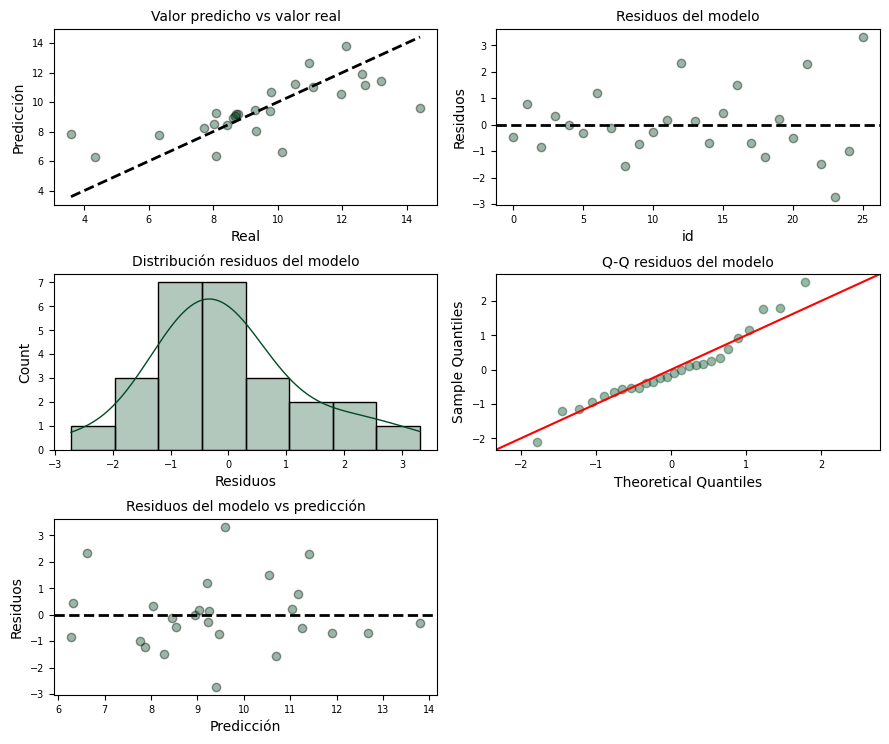

In [30]:
# Importar la librería Seaborn y establecer un esquema de color azul (celeste)

sns.set_palette("ocean")

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', color='black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize=7)

# 2 - Gráfico Residuos del Modelo
axes[0, 1].scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize=10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].tick_params(labelsize=7)

# 3 - Gráfico Distribución Residuos del Modelo
sns.histplot(data=residuos_train, stat="count", kde=True, line_kws={'linewidth': 1},alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuos")
axes[1, 0].tick_params(labelsize=7)

# 4 - Gráfico Q-Q Residuos del Modelo
sm.qqplot(residuos_train, fit=True, line='45', ax=axes[1, 1], color='black', alpha=0.4, lw=2)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

# 5 - Gráfico Residuos del Modelo vs Predicción
axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuos')
axes[2, 0].tick_params(labelsize=7)

# Eliminar los axes vacíos
fig.delaxes(axes[2, 1])

# Ajustar diseño de la figura y título
fig.tight_layout()
plt.subplots_adjust(top=0.9)
#fig.suptitle('Diagnóstico residuos RLM MEDIAS + CLIMA + INTERACCIONES', fontsize=12)

# Mostrar los gráficos
plt.show()
